 ## Defining the problem and assembling a dataset

- Kaggle Movie Review
  - https://www.kaggle.com/datasets/nltkdata/movie-review
- Binary Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

2023-02-26 13:00:17.407795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 13:00:19.519325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 13:00:19.519367: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-26 13:00:23.104085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
reviews = pd.read_csv('movie_review.csv', sep=',')
reviews = reviews[['text', 'tag']]

reviews.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [3]:
TEST_SIZE = 0.1

(text_train, text_test, 
 tag_train, tag_test) = train_test_split(reviews['text'], reviews['tag'], 
                                         test_size=TEST_SIZE, stratify=reviews['tag'],
                                                     shuffle=True, random_state=SEED)

In [4]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(text_train)

X_train, X_test = tfidf.transform(text_train).toarray(), tfidf.transform(text_test).toarray()

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(reviews['tag'])

y_train = label_encoder.transform(tag_train)
y_test = label_encoder.transform(tag_test)

In [6]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [7]:
counts = reviews.groupby(['tag']).count()
counts.reset_index(inplace=True)

counts

,tag,text
0,neg,31783
1,pos,32937


In [8]:
# the class is off-balanced, but very minimal 

baseline = counts[counts['tag']=='pos']['text'].values[0] / counts['text'].sum()

baseline

0.5089153275648949

In [9]:
balanced_accuracy_baseline = balanced_accuracy_score(y_train, np.zeros(len(y_train)))

In [10]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [11]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [12]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

2023-02-26 13:00:32.082616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-26 13:00:32.082637: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-26 13:00:32.082653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snottingham): /proc/driver/nvidia/version does not exist
2023-02-26 13:00:32.082850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
learning_rate = 0.001

slp_model = deep_neural_network(hidden_layers=0, 
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5001      
                                                                 
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


In [14]:
batch_size = 512
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [15]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 1.0181303338970387, 1: 0.9825040798512278}

In [16]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=500, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

2023-02-26 13:00:32.662668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1035520000 exceeds 10% of free system memory.


In [17]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.65 (baseline=0.51)
Precision (Validation): 0.66
Recall (Validation): 0.66
AUC (Validation): 0.72


In [18]:
preds = trained_slp_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

Balanced Accuracy (Validation): 0.65 (baseline=0.50)


In [19]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

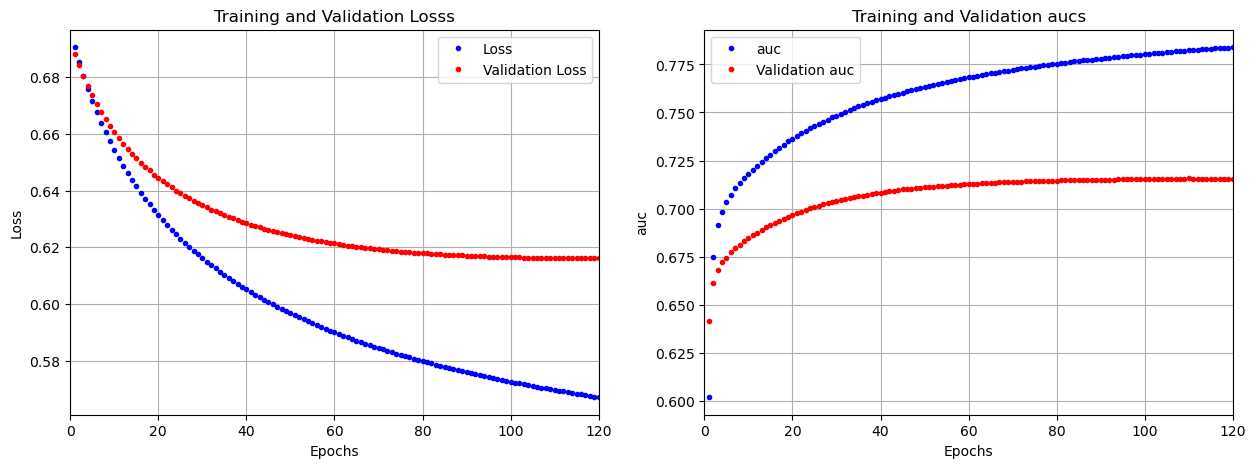

In [20]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [21]:
learning_rate = 0.0002

mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________


In [22]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

2023-02-26 13:01:58.508851: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1035520000 exceeds 10% of free system memory.


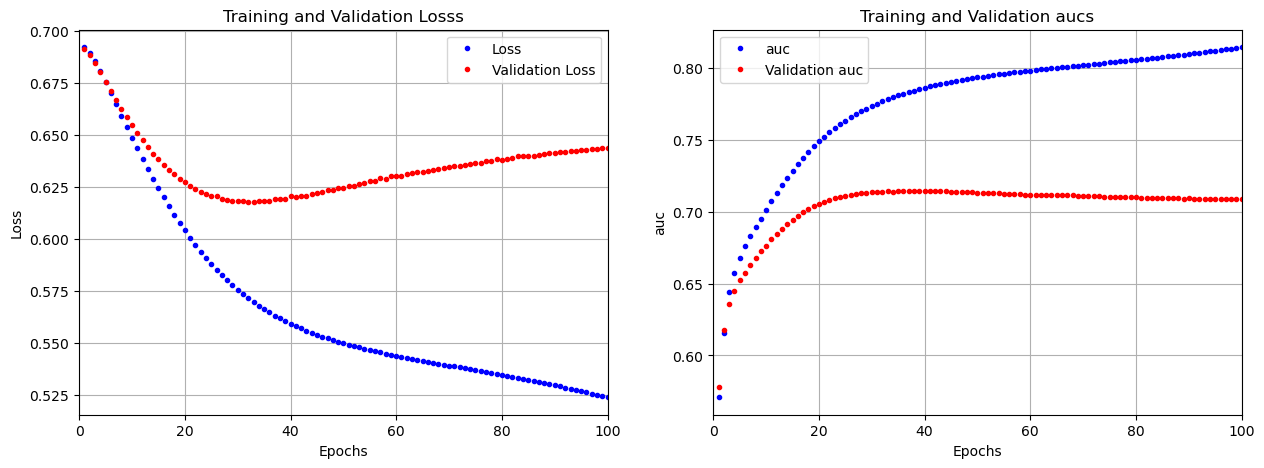

In [23]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [24]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.65 (baseline=0.51)
Precision (Validation): 0.65
Recall (Validation): 0.65
AUC (Validation): 0.71


In [25]:
preds = trained_mlp_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

Balanced Accuracy (Validation): 0.64 (baseline=0.50)


 ## Regularizing your model and tuning your hyperparameters

In [26]:
# Compute Balanced Accuracy Score for Softmax One-Hot Encoded Output
def compute_balanced_accuracy_score(y, preds) :
    return balanced_accuracy_score(y, (preds > 0.5).astype('int32'))

# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [27]:
# Grid Search CV
def grid_search_cv(X, y, class_weights, 
                   space, cv, 
                   learning_rate, loss, metrics, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=RMSprop(learning_rate=learning_rate), 
                                        loss=loss, metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                class_weights,
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate], verbose=0)[1:]
            for key, value in addon_metrics.items() :
                preds = trained['model'].predict(X[validate], verbose=0)
                evaluations.append( value(y[validate], preds) )
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [28]:
addon_metrics = {'balanced_accuracy': compute_balanced_accuracy_score}

orders = {
    0: 'categorical_accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
    4: 'balanced_accuracy'
}

In [29]:
KFOLDS = 5

In [30]:
params = {
    'hidden_layers': [1, 2],
    'neurons': [64],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [512]
}

learning_rate = 0.0002

stats = grid_search_cv(X_train, y_train,  
                       class_weights=CLASS_WEIGHTS,
                       space=params, cv=KFOLDS, 
                       learning_rate=learning_rate, 
                       loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       addon_metrics=addon_metrics, order=orders)

2023-02-26 13:06:23.574291: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 828400000 exceeds 10% of free system memory.
2023-02-26 13:07:25.253158: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 828420000 exceeds 10% of free system memory.
2023-02-26 13:08:38.882831: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 828420000 exceeds 10% of free system memory.


In [31]:
stats.sort_values(by=['auc'], ascending=False).head(10)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc,balanced_accuracy
0,1,64,relu,0.2,512,45.0,0.622094,0.651731,0.657062,0.660442,0.710086,0.651573
1,2,64,relu,0.2,512,21.4,0.623049,0.650688,0.657583,0.655054,0.709954,0.650609


In [34]:
learning_rate = 0.0002

opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                dropout=0.2, activation='relu',
                                input_dimension=INPUT_DIMENSION, 
                                output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Optimized_Deep_Network')

opt_model.summary()

Model: "Optimized_Deep_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                320064    
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________


In [35]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

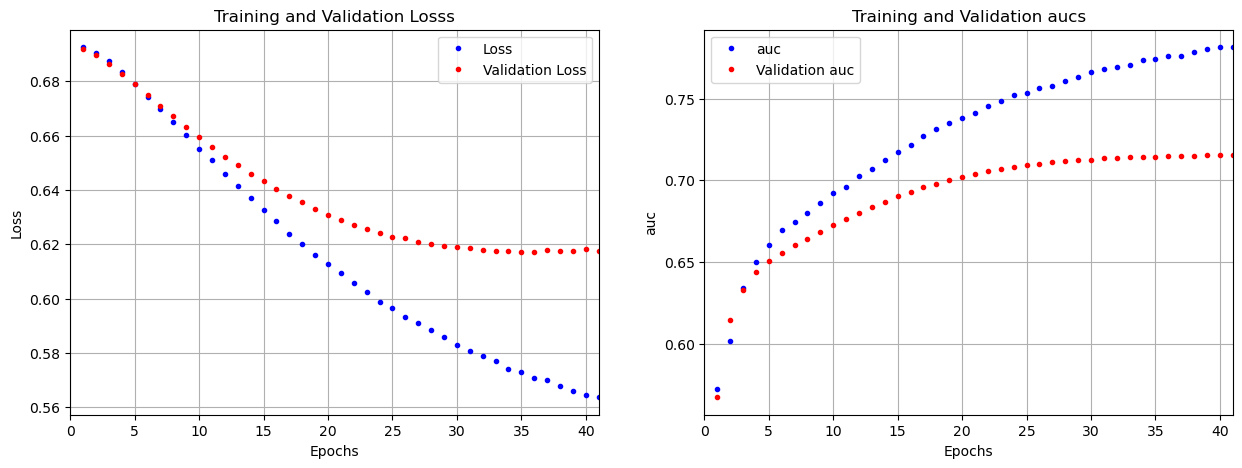

In [36]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [40]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.65 (baseline=0.51)
Precision (Validation): 0.66
Recall (Validation): 0.66
AUC (Validation): 0.71


In [39]:
preds = trained_opt_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

Balanced Accuracy (Validation): 0.65 (baseline=0.50)


In [44]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test, 
                                                                        (preds > 0.5).astype('int32')), 
                                                                        baseline ) )
print('Precision (Test): {:.2f}'.format(precision_score(y_test, 
                                                       (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, 
                                                  (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

Accuracy (Test): 0.65 (baseline=0.51)
Precision (Test): 0.66
Recall (Test): 0.66
AUC (Test): 0.71


In [46]:
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.33)'.format(balanced_accuracy_score(y_test, (preds > 0.5).astype('int32'))))

Balanced Accuracy (Validation): 0.65 (baseline = 0.33)


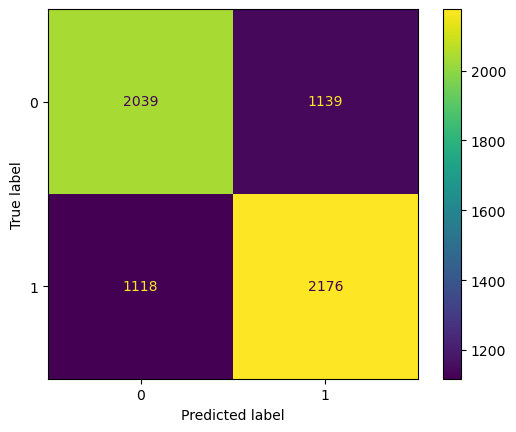

In [48]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
_ = disp.plot()